---
# <center> Master M2 MVA - Computational Statistics
    
# <center>  TP 4: Improve the Metropolis-Hasting algorithm
    
<center> Basile Terver
<center> terverbasile@gmail.com
    
    
--- 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

import scipy
from scipy.stats import multivariate_normal
from scipy.stats import invgamma
from numba import jit
from tqdm import tqdm
from IPython import get_ipython

## 1.A - Metropolis-Hastings with Gibbs sampler

In [4]:
def moving_average(x, window_size):
    cumsum = np.cumsum(x, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    cumsum[:window_size] /= np.arange(1, window_size + 1)
    cumsum[window_size:] /= window_size
    return cumsum


### Question 1

The transition kernel is Gaussian, thus symmetric, hence the acceptance ratio just involving the target density and not the transition kernel.

In [5]:
def target_density(x,y,a):
    square_x_on_a=np.square(x)/(a**2)
    square_y=np.square(y)
    return np.exp(-square_x_on_a -square_y-0.25*(square_x_on_a-square_y)**2 )

def log_target_density(x,y,a):
    square_x_on_a=np.square(x)/(a**2)
    square_y=np.square(y)
    return -square_x_on_a -square_y-0.25*(square_x_on_a-square_y)**2 

In [6]:
def proposal_kernel_x(x, y, sigma_x):
    # Update the x-component using P1
    x_prime = np.random.normal(x, sigma_x)
    y_prime = y

    return x_prime, y_prime

def proposal_kernel_y(x, y, sigma_y):
        # Update the y-component using P2
    x_prime = x
    y_prime = np.random.normal(y, sigma_y)

    return x_prime, y_prime

In [7]:
def mcmc_metropolis_hastings(initial_x, initial_y, a, sigma_x, sigma_y, num_samples):
    samples = [(initial_x, initial_y)]
    acceptance_list_x = [0]
    acceptance_list_y = [0]

    for i in range(1, num_samples):
        current_x, current_y = samples[-1]
        if np.random.rand() < 0.5: # Updating x 
            proposed_x, proposed_y = proposal_kernel_x(current_x, current_y, sigma_x)
            alpha = min(1, target_density(proposed_x, proposed_y, a) / target_density(current_x, current_y, a))
            if np.random.rand() < alpha: # Accepted
                samples.append((proposed_x, proposed_y))
                acceptance_list_x.append(1)
            else: # Rejected
                samples.append((current_x, current_y))
                acceptance_list_x.append(0)
            acceptance_list_y.append(acceptance_list_y[-1]) # Padding the list that was not updated
        else: # Updating y
            proposed_x, proposed_y = proposal_kernel_y(current_x, current_y, sigma_y)
            alpha = min(1, target_density(proposed_x, proposed_y, a) / target_density(current_x, current_y, a))
            if np.random.rand() < alpha: # Accepted
                samples.append((proposed_x, proposed_y))
                acceptance_list_y.append(1)
            else: # Rejected
                samples.append((current_x, current_y))
                acceptance_list_y.append(0)
            acceptance_list_x.append(acceptance_list_x[-1]) # Padding the list that was not updated
        
    return np.array(samples), np.array(acceptance_list_x), np.array(acceptance_list_y)
    

In [8]:
def mcmc_metropolis_hastings_using_log_alpha(initial_x, initial_y, a, sigma_x, sigma_y, num_samples):
    samples = [(initial_x, initial_y)]
    acceptance_list_x = [0]
    acceptance_list_y = [0]

    for i in range(1, num_samples):
        current_x, current_y = samples[-1]
        if np.random.rand() < 0.5: # Updating x 
            proposed_x, proposed_y = proposal_kernel_x(current_x, current_y, sigma_x)
            log_alpha = min(0, log_target_density(proposed_x, proposed_y, a) - log_target_density(current_x, current_y, a))
            if np.log(np.random.rand()) < log_alpha: # Accepted
                samples.append((proposed_x, proposed_y))
                acceptance_list_x.append(1)
            else: # Rejected
                samples.append((current_x, current_y))
                acceptance_list_x.append(0)
            acceptance_list_y.append(acceptance_list_y[-1]) # Padding the list that was not updated
        else: # Updating y
            proposed_x, proposed_y = proposal_kernel_y(current_x, current_y, sigma_y)
            log_alpha = min(0, log_target_density(proposed_x, proposed_y, a) - log_target_density(current_x, current_y, a))
            if np.log(np.random.rand()) < log_alpha: # Accepted
                samples.append((proposed_x, proposed_y))
                acceptance_list_y.append(1)
            else: # Rejected
                samples.append((current_x, current_y))
                acceptance_list_y.append(0)
            acceptance_list_x.append(acceptance_list_x[-1]) # Padding the list that was not updated
        
    return np.array(samples), np.array(acceptance_list_x), np.array(acceptance_list_y)
    

### Question 2

In [9]:
# Parameters
a = 10
sigma_x = 3
sigma_y = 3
num_samples = 20000
window_size=50

# Initial state
initial_x = np.random.uniform(-a, a)
initial_y = np.random.uniform(-a, a)
#initial_x=0
#initial_y=0

In [10]:
# Run MCMC algorithm
samples, acceptance_list_x, acceptance_list_y = mcmc_metropolis_hastings_using_log_alpha(initial_x, initial_y, a, sigma_x, sigma_y, num_samples)
samples_x=samples[:, 0]
samples_y=samples[:, 1]
# Calculate moving averages
acceptance_ma_x = moving_average(acceptance_list_x, window_size)
acceptance_ma_y = moving_average(acceptance_list_y, window_size)

#print('acceptance_ma_x=',acceptance_ma_x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


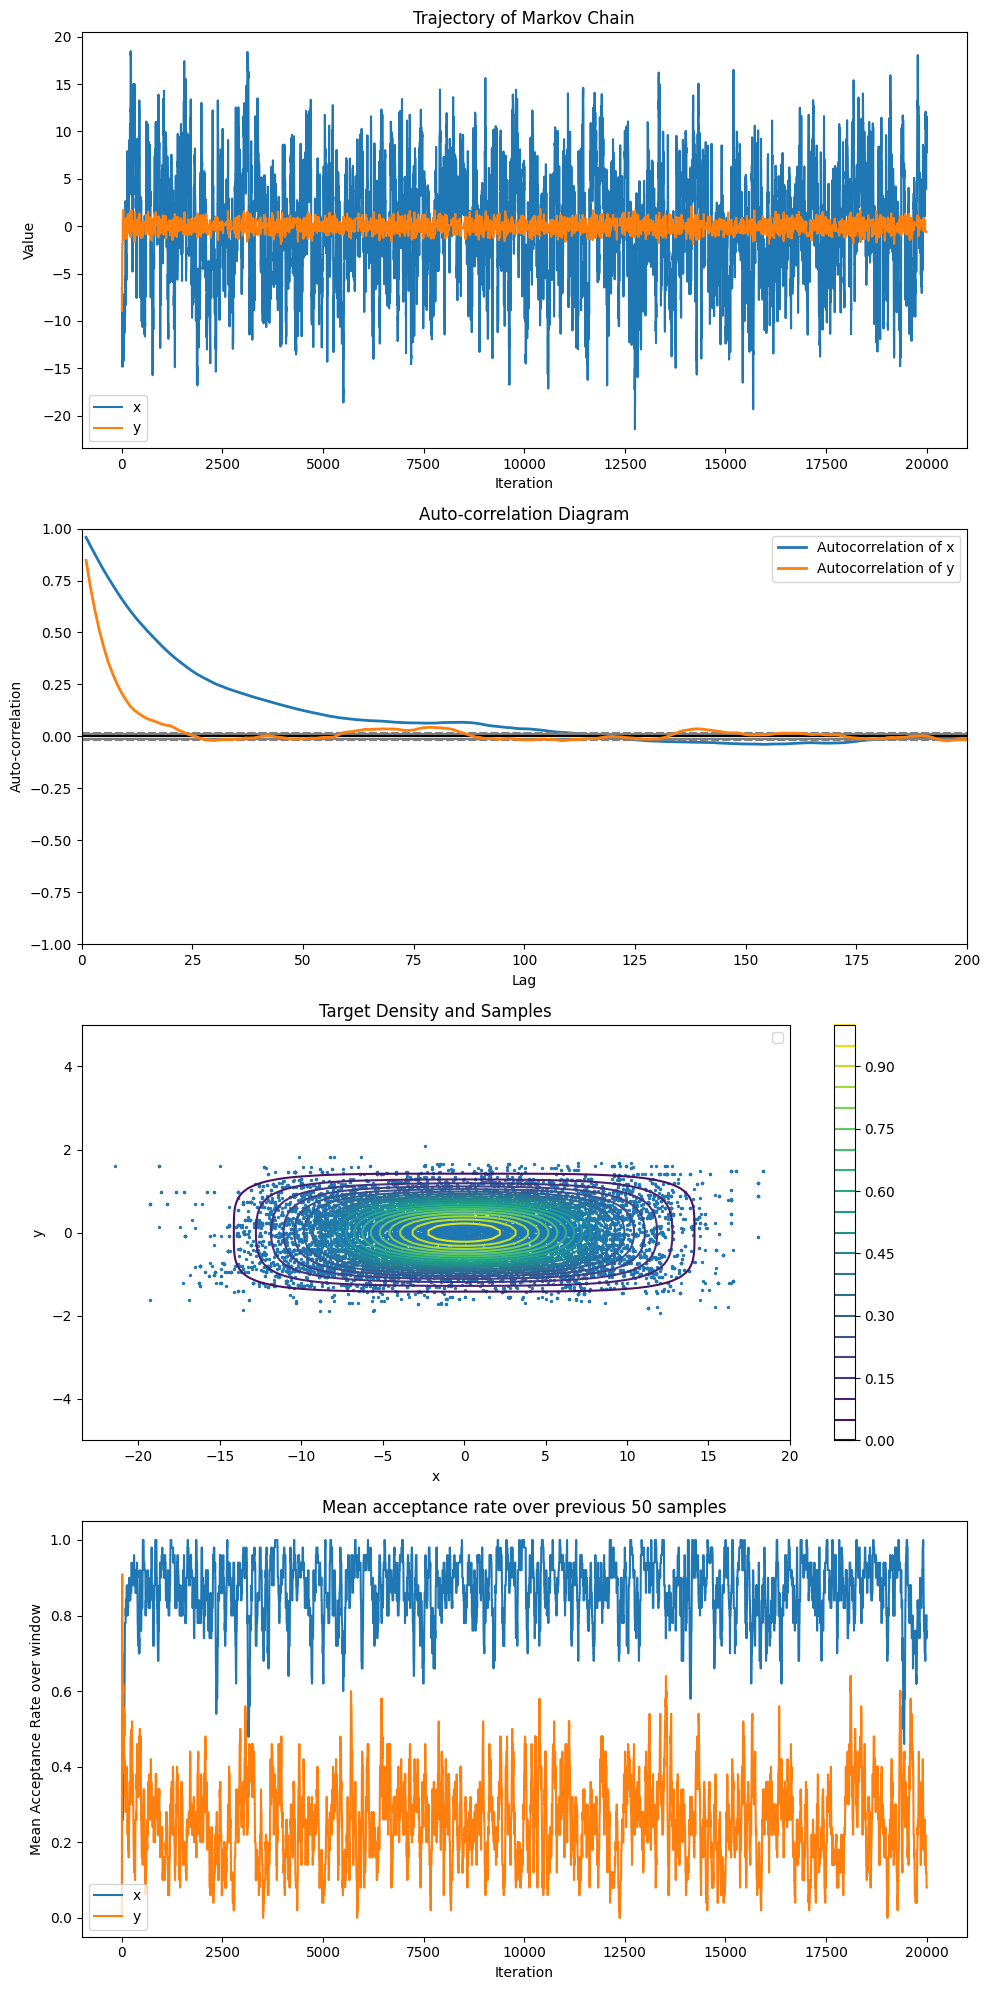

In [181]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(4, 1, 1)
plt.plot(samples_x, label='x')
plt.plot(samples_y, label='y')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(4, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = 'Autocorrelation of y',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,200))

# Plot target density and samples
plt.subplot(4, 1, 3)
plot_offset_x = 10
plot_offset_y = 5
x_range = np.linspace(-a - plot_offset_x, a + plot_offset_x, 100)
y_range = np.linspace(-a + plot_offset_y, a - plot_offset_y, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = target_density(X, Y, a)
contour = plt.contour(X, Y, Z, cmap='viridis', levels=20)

n_burnin = num_samples // 10
plt.scatter(samples[n_burnin:, 0], samples[n_burnin:, 1], s=2)

plt.title('Target Density and Samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour)

# Plot acceptance rate evolution
plt.subplot(4, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, acceptance_ma_x, label='x')
plt.plot(iterations, acceptance_ma_y, label='y')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

plt.tight_layout()
plt.show()


One can observe, on the autocorrelation diagram, that, even after 1000 iterations of the Hastings-Metropolis algorithm, the autocorrelation does not converge to 0, especially for the $x$ coordinate.

This is due to the fact that the acceptance rate for $x$ stays too high, which is caused by the proposal kernel's $\sigma_1$ parameter, which is too small, compared to the variance along the $x$-axis one can observe on the plot of the target density function. This low $\sigma_1$ does not allow the proposal kernel to explore the space far away enough from $x=0$.

### Question 3

## 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

### Question 1

We still use the same acceptance ratio as in 1.A because the marginal conditional distributions are proportional (up to a constant independent of $x_i$) to the joint distribution: $\pi_i(x_i|x_{-i}) \propto \pi(x_1,\dots,x_n)$.

In [187]:
def adaptive_mcmc_metropolis_hastings_Gibbs_using_log_alpha(initial_x, initial_y, a, initial_sigma_x, initial_sigma_y, num_samples):
    samples = [(initial_x, initial_y)]
    acceptance_list_x = [0]
    acceptance_list_y = [0]
    sigma_x=initial_sigma_x
    sigma_y=initial_sigma_y

    for i in range(1, num_samples):
        current_x, current_y = samples[-1]
        
        # Updating x with one step of HM
        proposed_x, proposed_y = proposal_kernel_x(current_x, current_y, sigma_x)
        log_alpha = min(0, log_target_density(proposed_x, proposed_y, a) - log_target_density(current_x, current_y, a))
        if np.log(np.random.rand()) < log_alpha: # Accepted
            current_x, current_y= proposed_x, proposed_y
            acceptance_list_x.append(1)
        else: # Rejected
            acceptance_list_x.append(0)
        samples.append(copy.deepcopy((current_x, current_y)))

        # Updating y with one step of HM
        proposed_x, proposed_y = proposal_kernel_y(current_x, current_y, sigma_y)
        log_alpha = min(0, log_target_density(proposed_x, proposed_y, a) - log_target_density(current_x, current_y, a))
        if np.log(np.random.rand()) < log_alpha: # Accepted
            current_x, current_y= proposed_x, proposed_y
            acceptance_list_y.append(1)
        else: # Rejected
            acceptance_list_y.append(0)
        samples.append(copy.deepcopy((current_x, current_y)))
        
        # Adaptation of the proposal distributions' parameters
        j=i//50
        if (j>0 and i%50==0):
            delta=min(0.01,1/np.sqrt(j))
            # Updating sigma_x
            acceptance_rate_batch_x=np.sum(acceptance_list_x[-50:])/50
            if acceptance_rate_batch_x>0.24:
                sigma_x=np.exp(np.log(sigma_x)+delta)
            else:
                sigma_x=np.exp(np.log(sigma_x)-delta)
            # Updating sigma_y
            acceptance_rate_batch_y=np.sum(acceptance_list_y[-50:])/50
            if acceptance_rate_batch_y>0.24:
                sigma_y=np.exp(np.log(sigma_y)+delta)
            else:
                sigma_y=np.exp(np.log(sigma_y)-delta)
             
    
    return np.array(samples), np.array(acceptance_list_x), np.array(acceptance_list_y)
    

In [190]:
# Parameters
a = 10
sigma_x = 3
sigma_y = 3
num_samples = 50000
window_size=50

# Initial state
initial_x=0.0
initial_y=0.0

# Run MCMC algorithm
samples, acceptance_list_x, acceptance_list_y = adaptive_mcmc_metropolis_hastings_Gibbs_using_log_alpha(initial_x, initial_y, a, sigma_x, sigma_y, num_samples)
samples_x=samples[:, 0]
samples_y=samples[:, 1]
# Calculate moving averages
adaptive_acceptance_ma_x = moving_average(acceptance_list_x, window_size)
adaptive_acceptance_ma_y = moving_average(acceptance_list_y, window_size)

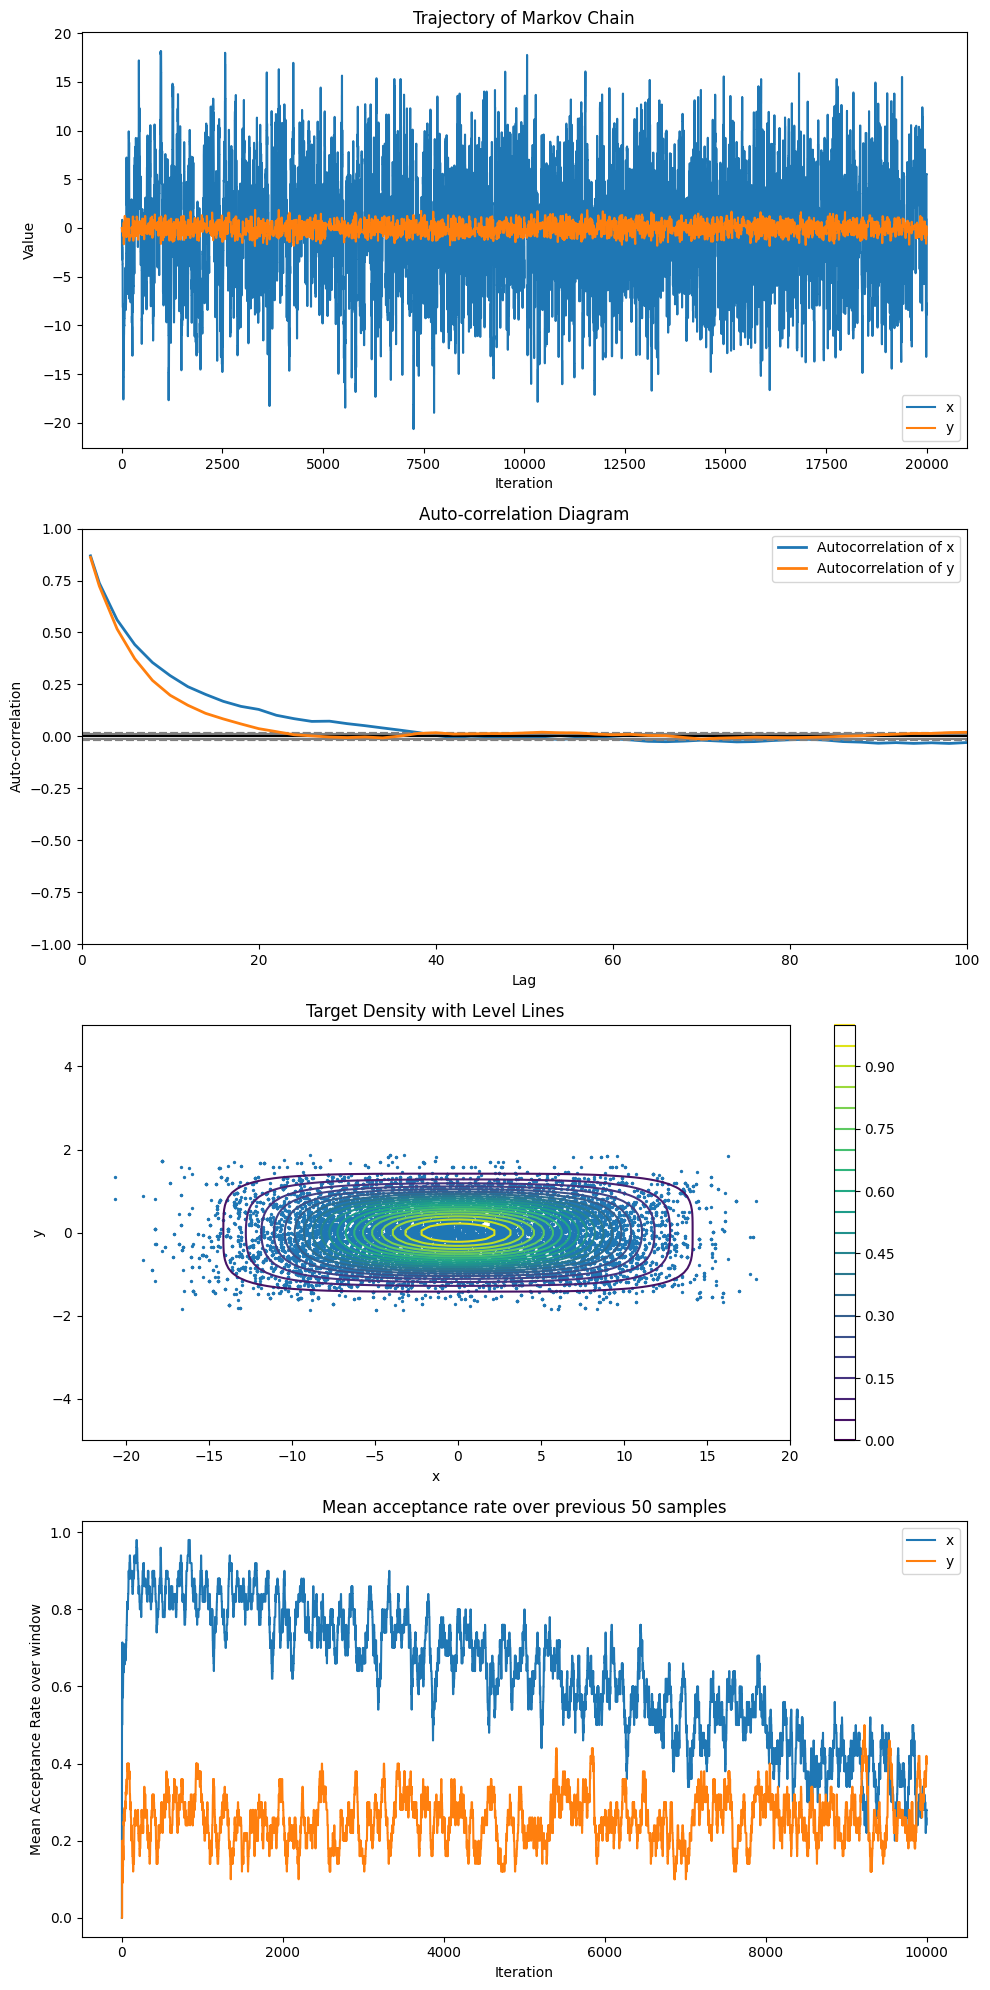

In [191]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(4, 1, 1)
plt.plot(samples_x, label='x')
plt.plot(samples_y, label='y')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(4, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = 'Autocorrelation of y',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,100))

# Plot target density and samples
plt.subplot(4, 1, 3)
plot_offset_x = 10
plot_offset_y = 5
x_range = np.linspace(-a - plot_offset_x, a + plot_offset_x, 100)
y_range = np.linspace(-a + plot_offset_y, a - plot_offset_y, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = target_density(X, Y, a)
contour = plt.contour(X, Y, Z, cmap='viridis', levels=20)

n_burnin = num_samples // 10
plt.scatter(samples[n_burnin:, 0], samples[n_burnin:, 1], s=2)

plt.title('Target Density with Level Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour)

# Plot acceptance rate evolution
plt.subplot(4, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, adaptive_acceptance_ma_x, label='x')
plt.plot(iterations, adaptive_acceptance_ma_y, label='y')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

plt.tight_layout()
plt.show()


One can observe that the mean acceptance rate of both coordinates converges to 0.24, especially the mean acceptance rate for $y$ which decreases a lot. This results in autocorrelation diagrams converging much faster to zero, indicating independent samples and therefore trustworthy sampling of the target distribution.

### Question 2

#### (i) TMALA Example

In [13]:
Sigma = np.array(pd.read_csv('tmalaexcov.txt' ,header=None , sep=' '))
print(Sigma)

[[ 9.75686747  6.02615139  7.05063557  8.21751985  6.82041096  8.55587287
   5.18063002  6.51909455  8.29677009 10.66329074  7.82992974  9.96116763
   1.84850408  4.21731767  8.0029984   8.96602617  5.95119451  9.89878028
   9.47283886  9.21287667]
 [ 6.02615139 10.590657   10.03422589 11.24318906  6.79876105  8.63184666
   6.35020852 11.71597318  9.96433056 10.11216124 11.03379994 10.88698935
   7.76882609  8.83602583  9.09034666 12.54114232  9.77776388 12.65661338
  12.11844006 10.64490779]
 [ 7.05063557 10.03422589 12.13350152 12.5740181   6.30935824  9.40288117
   6.91082118 11.59406648 10.37599225  9.79867232 10.75511027 12.36252479
   6.94347374  8.65248438  9.25018657 13.69731519 10.14666145 13.60980169
  13.16975521 11.46657087]
 [ 8.21751985 11.24318906 12.5740181  17.7593244   9.59007381 12.21532658
  12.10533921 13.30865639 12.65985594 10.29894955 13.35168591 12.42002065
  10.07540096  8.32723421  8.57878149 14.89255516 14.06754659 15.61941218
  13.88392256 14.54092206]
 [ 6

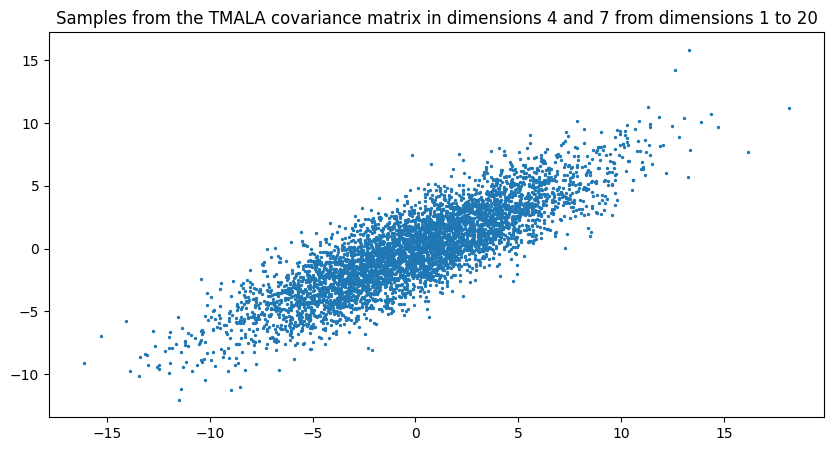

In [14]:
TMALA_data = np.random.multivariate_normal(np.zeros(20), Sigma, size = 5000)
dim_x=3
dim_y=6
plt.figure(figsize=(10, 5))
plt.scatter(TMALA_data[:,dim_x], TMALA_data[:,dim_y], s = 2)
plt.title(f'Samples from the TMALA covariance matrix in dimensions {dim_x+1} and {dim_y+1} from dimensions 1 to 20')
plt.show()

In [17]:
def log_target_density_TMALA(x,Sigma):
    return multivariate_normal.logpdf(x,mean=np.zeros(len(Sigma[0])),cov=Sigma)

def proposal_kernel_dim(x, sigma, dim):
    res=copy.deepcopy(x)
    res[dim]=np.random.normal(res[dim], sigma[dim])
    return res

In [18]:
def adaptive_mcmc_metropolis_hastings_Gibbs_TMALA(initial_x, initial_sigma, num_samples, dimension=20):
    samples = [initial_x]
    #print('inital samples=',samples)
    acceptance_list=np.zeros((num_samples,dimension))
    sigma=initial_sigma
    sigma_list=[initial_sigma]

    for i in tqdm(range(1, num_samples)):
        #print('i=',i)
        #print('sigma=',sigma)
        current_x= samples[-1]
        #print('current_x before loop on dimensions=',current_x)
        for dim in range(dimension):
            # Updating x with one step of HM
            proposed_x = proposal_kernel_dim(current_x, sigma,dim)
            log_alpha = min(0, log_target_density_TMALA(proposed_x, Sigma) - log_target_density_TMALA(current_x, Sigma))
            log_u=np.log(np.random.rand())
            """
            print('dim=',dim)
            print('proposed_x=',proposed_x)
            print('current_x',current_x)
            print('log_alpha=',log_alpha)
            print('log_u=',log_u)
            """
            if  log_u < log_alpha: # Accepted
                acceptance_list[i,dim]=1
                current_x=proposed_x
                #print('Accepted')
            else: # Rejected
                acceptance_list[i,dim]=0
                #print('Rejected')
        #print('current_x after loop on dimensions=',current_x)
        samples.append(copy.deepcopy(current_x))
            
        # Adaptation of the proposal distributions' parameters
        j=i//50
        #print('i=',i)
        #print('j=',j)
        if (j>0 and i%50==0):
            delta=min(0.01,1/np.sqrt(j))
            for dim in range(dimension):
                acceptance_rate_batch_dim=np.sum(acceptance_list[i-50:i,dim])/50
                #print(f'acceptance_rate_batch_dim{dim+1}=',acceptance_rate_batch_dim)
                if acceptance_rate_batch_dim>0.24:
                    #l=np.log(sigma[dim])+delta
                    #sigma[dim]=np.exp(l)
                    sigma[dim]=np.exp(np.log(sigma[dim])+delta)
                else:
                    #l=np.log(sigma[dim])-delta
                    #sigma[dim]=np.exp(l)
                    sigma[dim]=np.exp(np.log(sigma[dim])-delta)
            sigma_list.append(copy.deepcopy(sigma))
            
    return np.array(samples), acceptance_list, np.array(sigma_list)
    

In [302]:
# Parameters
dimension = len(Sigma[0])
initial_sigma = np.ones(20)
num_samples = 15000
window_size=50

# Initial state
initial_x=np.zeros(shape=dimension)

# Run MCMC algorithm
samples, acceptance_list,sigma_list = adaptive_mcmc_metropolis_hastings_Gibbs_TMALA(initial_x, initial_sigma, num_samples)

100%|██████████| 14999/14999 [05:41<00:00, 43.87it/s]


In [303]:
#print('samples shape=',samples.shape)
#print('samples=',samples)
samples_x=samples[:, dim_x]
samples_y=samples[:, dim_y]
# Calculate moving averages
adaptive_acceptance_ma_x = moving_average(acceptance_list[:,dim_x], window_size)
adaptive_acceptance_ma_y = moving_average(acceptance_list[:,dim_y], window_size)
# Proposition parameters
sigma_prop_x = sigma_list[:,dim_x]
sigma_prop_y = sigma_list[:,dim_y]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


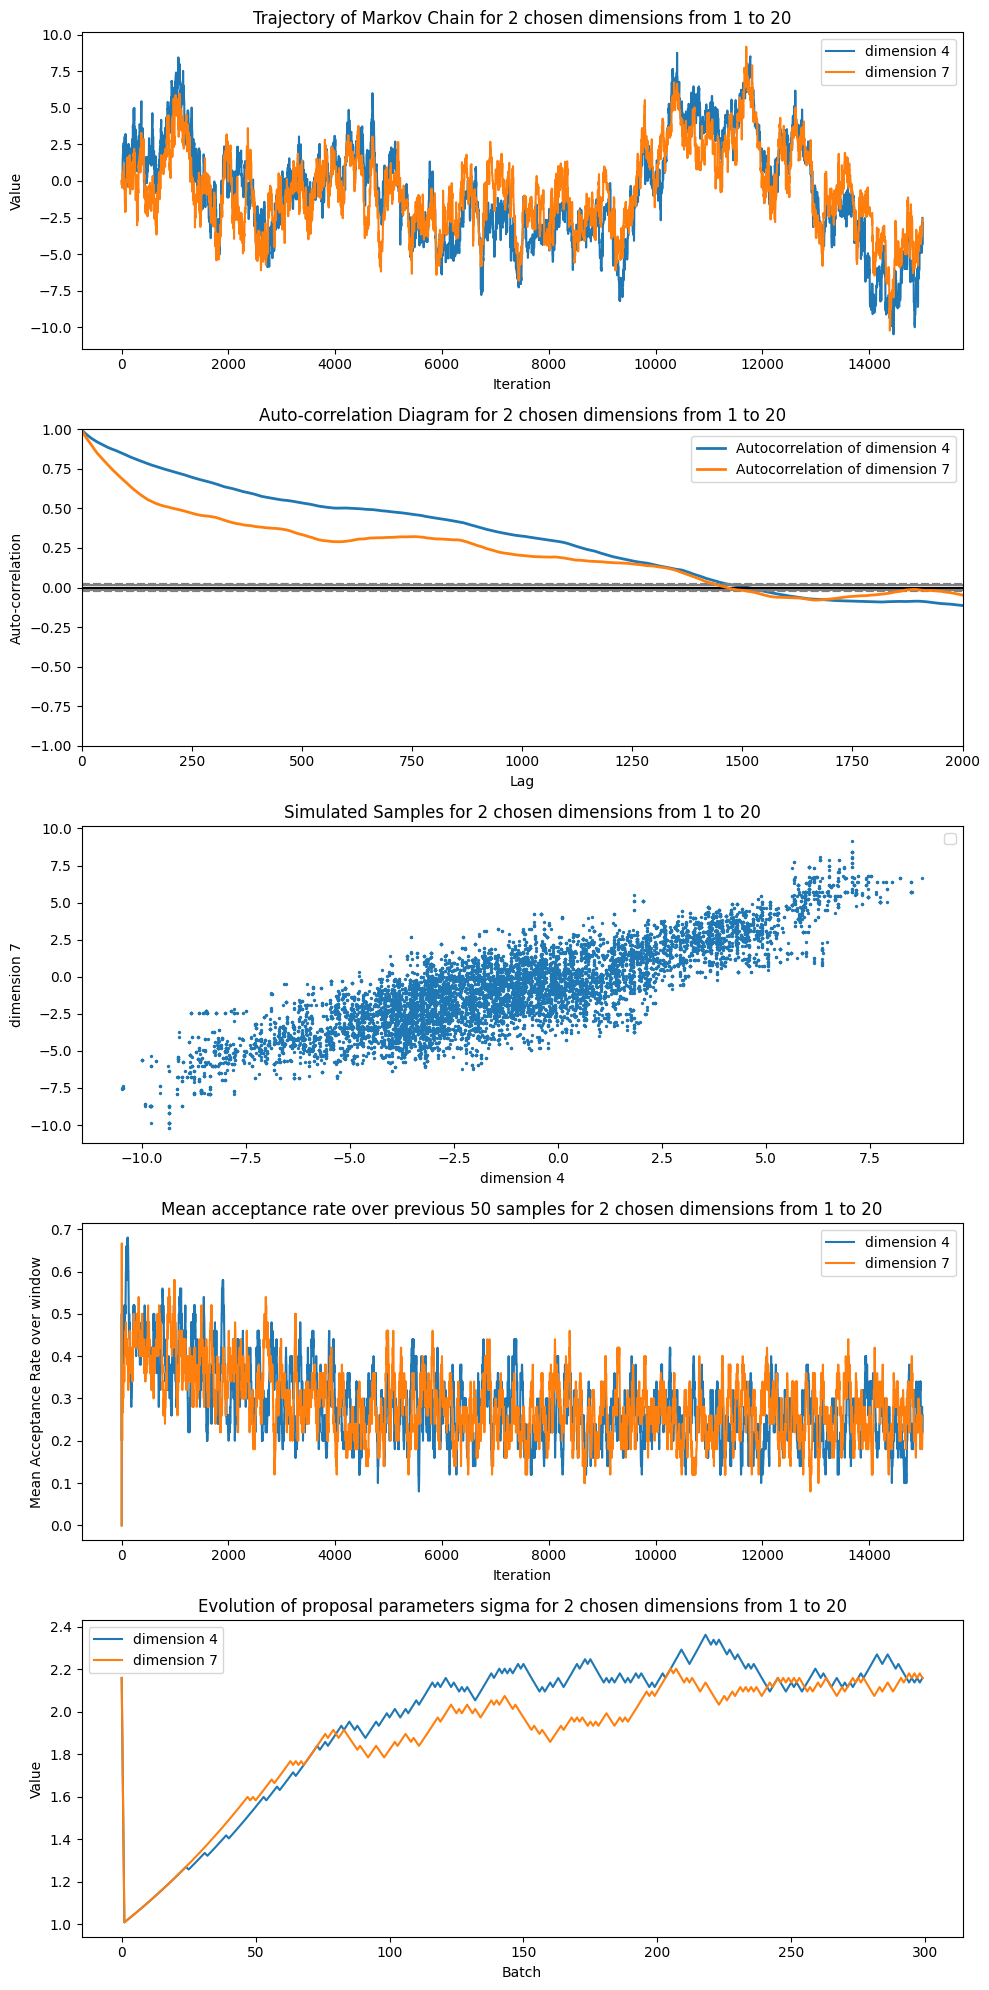

In [307]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(5, 1, 1)
plt.plot(samples_x, label=f'dimension {dim_x+1}')
plt.plot(samples_y, label=f'dimension {dim_y+1}')
plt.title('Trajectory of Markov Chain for 2 chosen dimensions from 1 to 20')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(5, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label=f'Autocorrelation of dimension {dim_x+1}',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = f'Autocorrelation of dimension {dim_y+1}',linewidth=2)
plt.title('Auto-correlation Diagram for 2 chosen dimensions from 1 to 20')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,2000))

#Plot samples
n_burnin = num_samples // 10
plt.subplot(5, 1, 3)
plt.scatter(samples[n_burnin:, dim_x], samples[n_burnin:, dim_y], s=2)
plt.title('Simulated Samples for 2 chosen dimensions from 1 to 20')
plt.xlabel(f'dimension {dim_x+1}')
plt.ylabel(f'dimension {dim_y+1}')
plt.legend()

# Plot acceptance rate evolution
plt.subplot(5, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, adaptive_acceptance_ma_x, label=f'dimension {dim_x+1}')
plt.plot(iterations, adaptive_acceptance_ma_y, label=f'dimension {dim_y+1}')
plt.title(f'Mean acceptance rate over previous {window_size} samples for 2 chosen dimensions from 1 to 20')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

# Plot proposition sigma evolution
plt.subplot(5, 1, 5)
batches = np.arange(len(sigma_prop_x))
plt.plot(batches, sigma_prop_x, label=f'dimension {dim_x+1}')
plt.plot(batches, sigma_prop_y, label=f'dimension {dim_y+1}')
plt.title(f'Evolution of proposal parameters sigma for 2 chosen dimensions from 1 to 20')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


#### (ii) Banana shape density

Let us reuse the code of TP2 to generate a sample from the Banana-shape density. We now prove that the formula for the density provided corresponds to the formula of the density in TP2 with $\sigma_1=10$.

Denote $C=\textrm{diag}(\sigma_1^2,1,\dots,1)$, then $ \textrm{det}(C)=\sigma_1^2$ and if $\Phi$ denotes the density function of the $d$-dimensional Gaussian with mean $0$ and covariance $C$, we have
$$ \nu(x)\propto \exp\left(-\frac{1}{2}G(x)^\top C^{-1} G(x) \right),
$$
with $G(x):=(x_1,x_2+b(x_1^2-\sigma_1^2),x_3,\dots,x_d)$.
Thus 
\begin{align*}
G(x)^\top C^{-1} G(x)=x_1^2\sigma_1^{-2}+[x_2+b(x_1^2-\sigma_1^2)]^2+x_3^3+\dots+x_d^2
\end{align*}
Thus, by identification of the coefficient associated to $x_1$, the density given in TP4 corresponds to the one of TP2 with $B=b$ and $\sigma_1=10$.

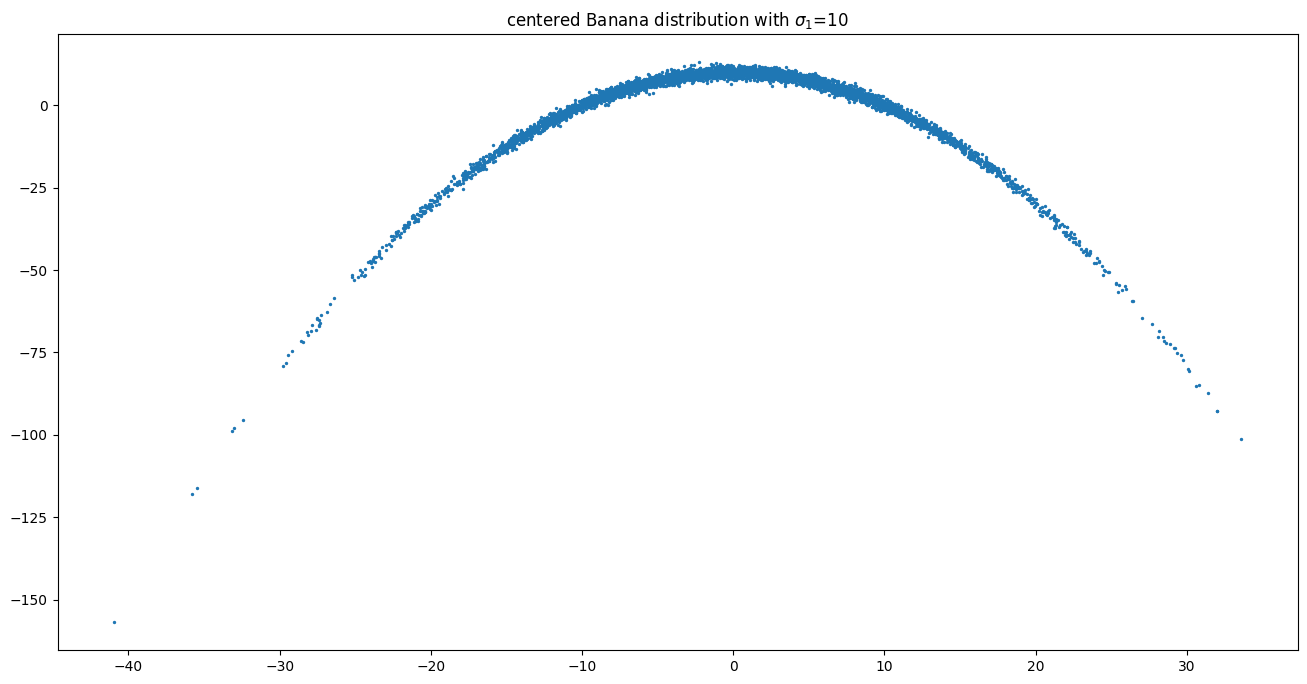

In [19]:
def Banana_sample(dimension, sigma, B , num_samples):
    Sigma = np.eye(dimension)
    Sigma[0,0] = sigma**2

    X = np.random.multivariate_normal(np.zeros(dimension), Sigma, size = num_samples)
    X[:,1] -= B*(X[:,0]**2 - sigma**2)

    return X

dimension=20
B=0.1
sigma_banana=10
num_samples=5000

#Plot projection on two first coordinates of the banana distribution
X = Banana_sample(dimension, sigma_banana, B , num_samples)
plt.figure(figsize=(16, 8))
plt.scatter(X[:,0], X[:,1], s = 2)
plt.title(fr"centered Banana distribution with $\sigma_1$={sigma_banana}")
plt.show()

In [20]:
#@jit(nopython=True)
def log_target_density_Banana(x,B):
    return -(x[0]**2)/200.-(0.5)*(x[1]+B*x[0]**2-100*B)**2-(0.5)*(np.sum(x[2:]**2))

In [21]:
def adaptive_mcmc_metropolis_hastings_Gibbs_Banana(initial_x, initial_sigma, num_samples, dimension=20):
    samples = [initial_x]
    acceptance_list=np.zeros((num_samples,dimension))
    sigma=initial_sigma
    sigma_list=[initial_sigma]

    for i in tqdm(range(1, num_samples)):
        current_x= samples[-1]
        for dim in range(dimension):
            # Updating x with one step of HM
            proposed_x = proposal_kernel_dim(current_x, sigma,dim)
            log_alpha = min(0, log_target_density_Banana(proposed_x, B) - log_target_density_Banana(current_x, B))
            log_u=np.log(np.random.rand())
            if  log_u < log_alpha: # Accepted
                acceptance_list[i,dim]=1
                current_x=proposed_x
            else: # Rejected
                acceptance_list[i,dim]=0
        samples.append(copy.deepcopy(current_x))
            
        # Adaptation of the proposal distributions' parameters
        j=i//50
        if (j>0 and i%50==0):
            delta=min(0.01,1/np.sqrt(j))
            for dim in range(dimension):
                acceptance_rate_batch_dim=np.sum(acceptance_list[i-50:i,dim])/50
                if acceptance_rate_batch_dim>0.24:
                    sigma[dim]=np.exp(np.log(sigma[dim])+delta)
                else:
                    sigma[dim]=np.exp(np.log(sigma[dim])-delta)
            sigma_list.append(copy.deepcopy(sigma))
            
    return np.array(samples), acceptance_list, np.array(sigma_list)
    

In [22]:
# Parameters
initial_sigma = np.ones(20)
num_samples = 50000
window_size=50

# Initial state
initial_x=np.zeros(shape=dimension)

# Run MCMC algorithm
samples, acceptance_list,sigma_list = adaptive_mcmc_metropolis_hastings_Gibbs_Banana(initial_x, initial_sigma, num_samples)

100%|██████████| 49999/49999 [00:14<00:00, 3432.05it/s]


In [23]:
# Dimensions to look at
dim_x=0
dim_y=1

samples_x=samples[:, dim_x]
samples_y=samples[:, dim_y]
# Calculate moving averages
adaptive_acceptance_ma_x = moving_average(acceptance_list[:,dim_x], window_size)
adaptive_acceptance_ma_y = moving_average(acceptance_list[:,dim_y], window_size)
# Proposition parameters
sigma_prop_x = sigma_list[:,dim_x]
sigma_prop_y = sigma_list[:,dim_y]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


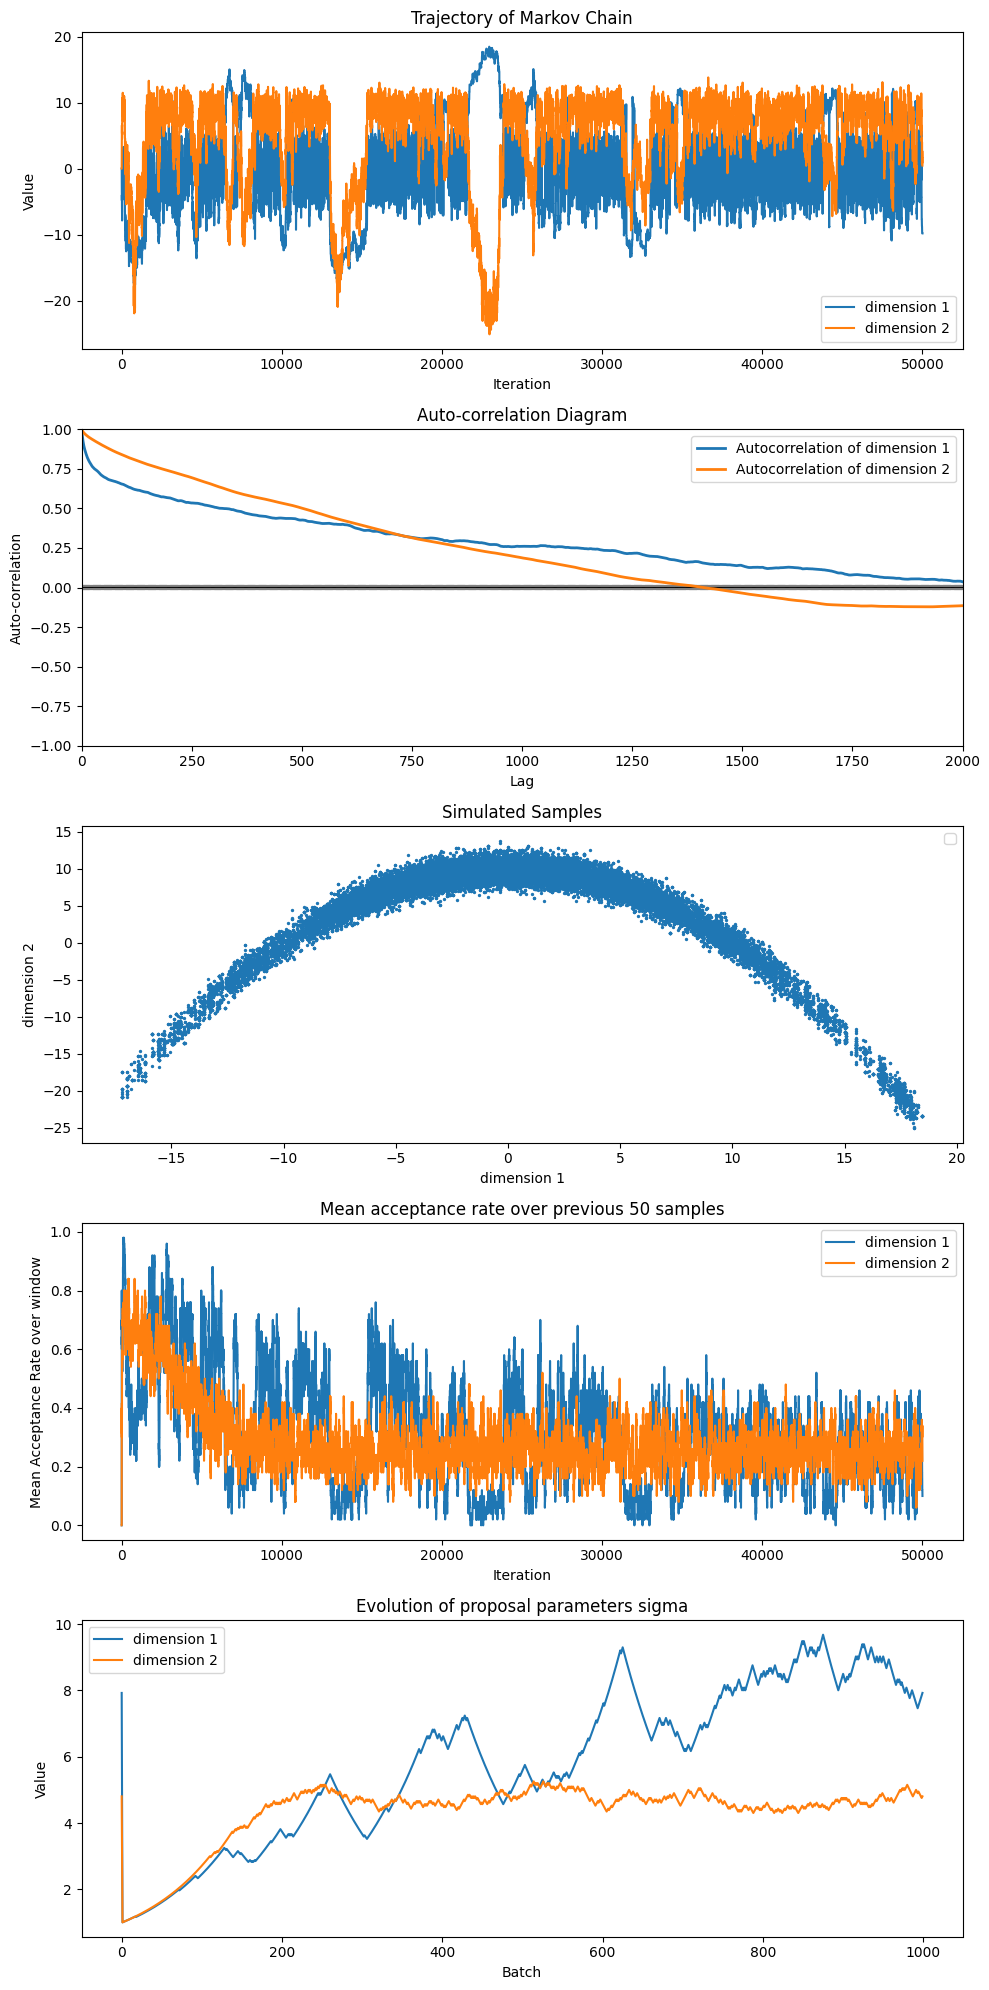

In [24]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(5, 1, 1)
plt.plot(samples_x, label=f'dimension {dim_x+1}')
plt.plot(samples_y, label=f'dimension {dim_y+1}')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(5, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label=f'Autocorrelation of dimension {dim_x+1}',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = f'Autocorrelation of dimension {dim_y+1}',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,2000))

#Plot samples
n_burnin = num_samples // 10
plt.subplot(5, 1, 3)
plt.scatter(samples[n_burnin:, dim_x], samples[n_burnin:, dim_y], s=2)
plt.title('Simulated Samples')
plt.xlabel(f'dimension {dim_x+1}')
plt.ylabel(f'dimension {dim_y+1}')
plt.legend()

# Plot acceptance rate evolution
plt.subplot(5, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, adaptive_acceptance_ma_x, label=f'dimension {dim_x+1}')
plt.plot(iterations, adaptive_acceptance_ma_y, label=f'dimension {dim_y+1}')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

# Plot proposition sigma evolution
plt.subplot(5, 1, 5)
batches = np.arange(len(sigma_prop_x))
plt.plot(batches, sigma_prop_x, label=f'dimension {dim_x+1}')
plt.plot(batches, sigma_prop_y, label=f'dimension {dim_y+1}')
plt.title(f'Evolution of proposal parameters sigma')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


## Exercise 2: Sampling from multimodal distributions

### 2.A - A toy example

In [25]:
# Parameters
dimension=2
num_gaussians = 20
mus = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
w = 0.05 * np.ones(num_gaussians)
sigmas = 0.1 * np.ones(num_gaussians)

In [26]:
#@jit(nopython=True)
def target_density_GMM(x, num_gaussians, mus, sigmas, w):
    return np.sum([w[i]/(np.sqrt(2*np.pi)*sigmas[i]) * np.exp( -np.linalg.norm(x-mus[i])**2 / (2*sigmas[i]**2) ) for i in range(num_gaussians)])

In [27]:
def mcmc_metropolis_hastings_Gibbs_GMM(initial_x, \
                                       initial_sigma, num_samples, adaptive=True, dimension=2):
    samples = [initial_x]
    acceptance_list=np.zeros((num_samples,dimension))
    sigma=initial_sigma
    sigma_list=[initial_sigma]

    for i in tqdm(range(1, num_samples)):
        current_x= samples[-1]
        for dim in range(dimension):
            # Updating x with one step of HM
            proposed_x = proposal_kernel_dim(current_x, sigma,dim)
            alpha = min(1, target_density_GMM(proposed_x,num_gaussians,mus,sigmas,w)/ target_density_GMM(current_x,num_gaussians,mus,sigmas,w))
            u=np.random.rand()
            if  u < alpha: # Accepted
                acceptance_list[i,dim]=1
                current_x=proposed_x
            else: # Rejected
                acceptance_list[i,dim]=0
        samples.append(copy.deepcopy(current_x))
            
        # Adaptation of the proposal distributions' parameters
        if adaptive:
            j=i//50
            if (j>0 and i%50==0):
                delta=min(0.01,1/np.sqrt(j))
                for dim in range(dimension):
                    acceptance_rate_batch_dim=np.sum(acceptance_list[i-50:i,dim])/50
                    if acceptance_rate_batch_dim>0.24:
                        sigma[dim]=np.exp(np.log(sigma[dim])+delta)
                    else:
                        sigma[dim]=np.exp(np.log(sigma[dim])-delta)
                sigma_list.append(copy.deepcopy(sigma))
            
    return np.array(samples), acceptance_list, np.array(sigma_list)
    

In [28]:
# Parameters
initial_sigma = np.ones(dimension)*4
num_samples = 50000
window_size=50

# Initial state
initial_x=np.ones(shape=dimension)

# Run MCMC algorithm
samples, acceptance_list,sigma_list = mcmc_metropolis_hastings_Gibbs_GMM(initial_x, initial_sigma, num_samples)

100%|██████████| 49999/49999 [00:22<00:00, 2194.00it/s]


In [29]:
# Dimensions to look at
dim_x=0
dim_y=1
# Rename samples per dimension
samples_x=samples[:, dim_x]
samples_y=samples[:, dim_y]
# Calculate moving averages
adaptive_acceptance_ma_x = moving_average(acceptance_list[:,dim_x], window_size)
adaptive_acceptance_ma_y = moving_average(acceptance_list[:,dim_y], window_size)
# Proposition parameters
sigma_prop_x = sigma_list[:,dim_x]
sigma_prop_y = sigma_list[:,dim_y]

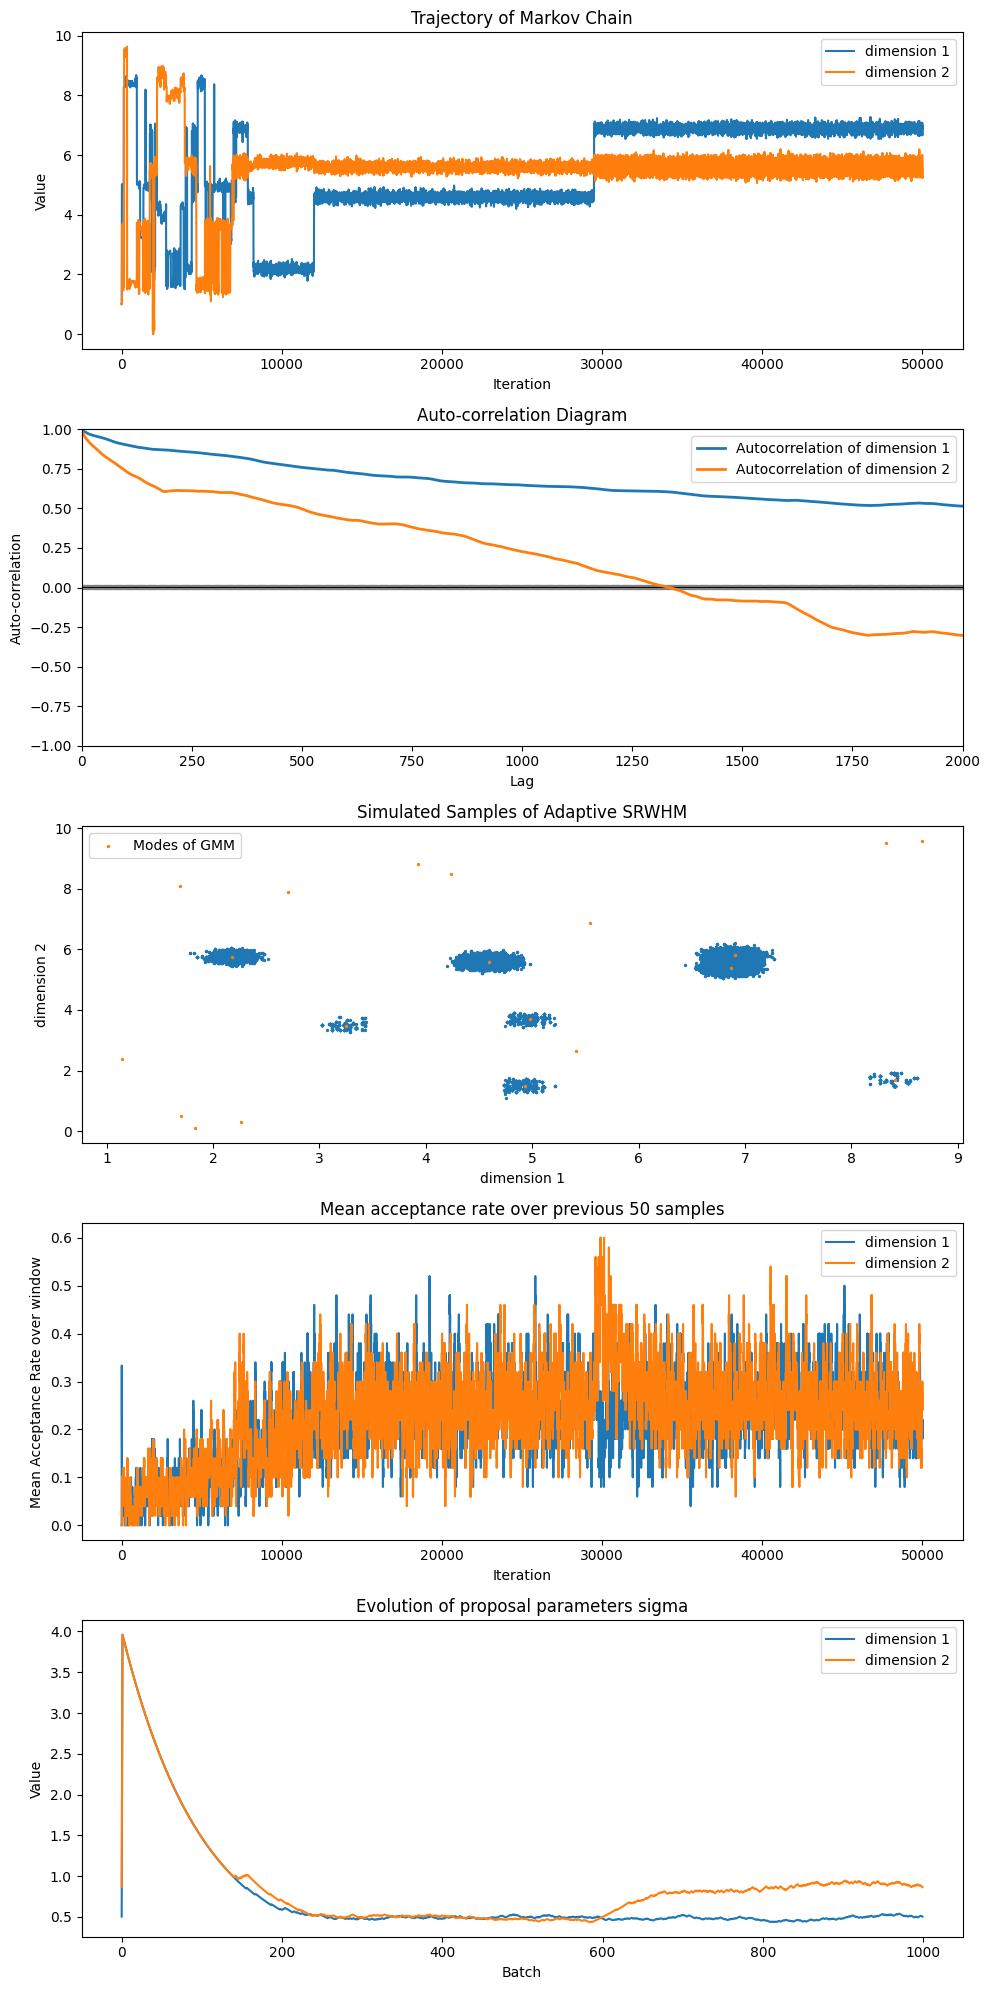

In [31]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(5, 1, 1)
plt.plot(samples_x, label=f'dimension {dim_x+1}')
plt.plot(samples_y, label=f'dimension {dim_y+1}')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(5, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label=f'Autocorrelation of dimension {dim_x+1}',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = f'Autocorrelation of dimension {dim_y+1}',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,2000))

#Plot samples
n_burnin = num_samples // 10
plt.subplot(5, 1, 3)
plt.scatter(samples[n_burnin:, dim_x], samples[n_burnin:, dim_y], s=2)
plt.scatter(mus[:, dim_x], mus[:, dim_y], s=2, label='Modes of GMM')
plt.title('Simulated Samples of Adaptive SRWHM')
plt.xlabel(f'dimension {dim_x+1}')
plt.ylabel(f'dimension {dim_y+1}')
plt.legend()

# Plot acceptance rate evolution
plt.subplot(5, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, adaptive_acceptance_ma_x, label=f'dimension {dim_x+1}')
plt.plot(iterations, adaptive_acceptance_ma_y, label=f'dimension {dim_y+1}')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

# Plot proposition sigma evolution
plt.subplot(5, 1, 5)
batches = np.arange(len(sigma_prop_x))
plt.plot(batches, sigma_prop_x, label=f'dimension {dim_x+1}')
plt.plot(batches, sigma_prop_y, label=f'dimension {dim_y+1}')
plt.title(f'Evolution of proposal parameters sigma')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
# Run MCMC algorithm
samples, acceptance_list,sigma_list = mcmc_metropolis_hastings_Gibbs_GMM(initial_x, initial_sigma, num_samples,adaptive=False)

# Rename samples per dimension
samples_x=samples[:, dim_x]
samples_y=samples[:, dim_y]
# Calculate moving averages
acceptance_ma_x = moving_average(acceptance_list[:,dim_x], window_size)
acceptance_ma_y = moving_average(acceptance_list[:,dim_y], window_size)

100%|██████████| 49999/49999 [00:22<00:00, 2200.48it/s]


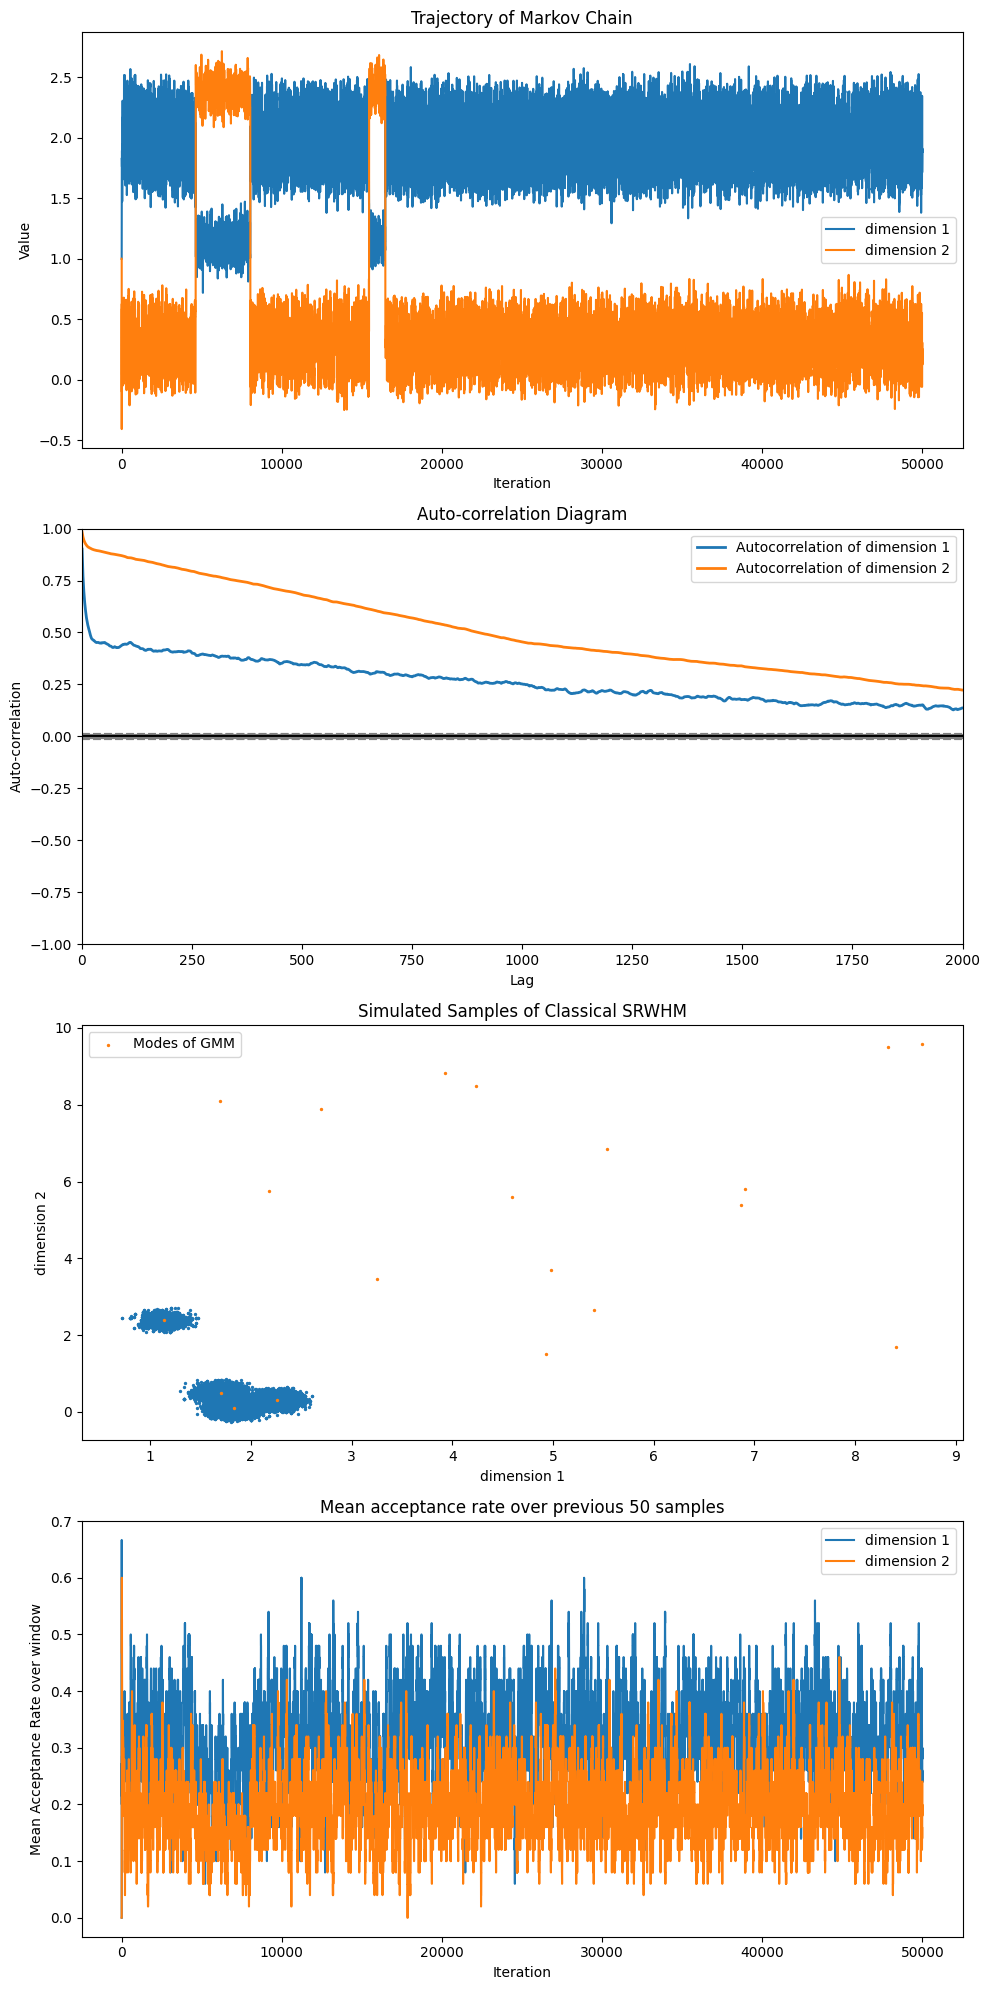

In [34]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 20))

# Plot trajectory
plt.subplot(4, 1, 1)
plt.plot(samples_x, label=f'dimension {dim_x+1}')
plt.plot(samples_y, label=f'dimension {dim_y+1}')
plt.title('Trajectory of Markov Chain')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot auto-correlation diagram
plt.subplot(4, 1, 2)
pd.plotting.autocorrelation_plot(samples_x, label=f'Autocorrelation of dimension {dim_x+1}',linewidth=2)
pd.plotting.autocorrelation_plot(samples_y, label = f'Autocorrelation of dimension {dim_y+1}',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,2000))

#Plot samples
n_burnin = num_samples // 10
plt.subplot(4, 1, 3)
plt.scatter(samples[n_burnin:, dim_x], samples[n_burnin:, dim_y], s=2)
plt.scatter(mus[:, dim_x], mus[:, dim_y], s=2, label='Modes of GMM')
plt.title('Simulated Samples of Classical SRWHM')
plt.xlabel(f'dimension {dim_x+1}')
plt.ylabel(f'dimension {dim_y+1}')
plt.legend()

# Plot acceptance rate evolution
plt.subplot(4, 1, 4)
iterations = np.arange(1, num_samples + 1)
plt.plot(iterations, acceptance_ma_x, label=f'dimension {dim_x+1}')
plt.plot(iterations, acceptance_ma_y, label=f'dimension {dim_y+1}')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

plt.tight_layout()
plt.show()


The Classical Stochastic Random Walk Hastings-Metropolis (SRWHM) algorithm only samples one mode of the Gaussian Mixture Model (GMM), so it definitely fails to sample from $\pi$, even though its autocorrelation diagram might indicate a good sampling, it is only an accurate sampling of one mode.

Even the Adaptive SRWHM only samples a few (7 out of 20 one the plot above) of the modes of the GMM. This is due to the fact that of the probability density function is very steep between the modes so it is very unlikely that a proposed sample that is closer to another mode is accepted, and therefore it is very unlikely that the Markov Chain goes from one mode to another.

## 2.B - Parallel Tempering 

There is no need for an aptation of the proposal distributions' parameters since it is said in the handout that "the scale parameters $\tau_i$ are tuned to ensure a reasonable acceptance rate in the algorithm".

In [94]:
def proposal_kernel_bivariate(x, tau):
    res=copy.deepcopy(x)
    res+=np.random.normal(size=len(res))*tau
    return res

def target_density_tempered_GMM(x, num_gaussians, mus, sigmas, w, temperature):
    return target_density_GMM(x, num_gaussians, mus, sigmas, w)**(1/temperature)

def hastings_metropolis_one_step_bivariate_kernel_tempered_GMM(x,tau,num_gaussians,sigmas,w, temperature):
    proposed_x = proposal_kernel_bivariate(x, tau)
    alpha = min(1, target_density_tempered_GMM(proposed_x,num_gaussians,mus,sigmas,w, temperature)/ \
         target_density_tempered_GMM(x,num_gaussians,mus,sigmas,w, temperature))
    u=np.random.rand()
    if  u < alpha: # Accepted
        return proposed_x,1
    else: # Rejected
        return x,0
    
def draw_uniformly_indices(k):
    list=[i for i in range(k)]
    pairs=[(i,j) for i in list for j in list if np.abs(i-j)==1]
    num_pairs=len(pairs)
    u=np.random.randint(num_pairs)
    return pairs[u]

In [95]:
def Parallel_tempering_MCMC_metropolis_hastings_GMM(initial_x, num_samples, \
        temperatures, num_gaussians, sigmas, w, dimension=2):
    K=len(temperatures)
    samples = [initial_x]
    acceptance_list=np.zeros((num_samples,K))
    tau=0.25*np.sqrt(temperatures)
    # Buffer for proposals
    new_x=initial_x

    for i in tqdm(range(1, num_samples)):
        current_x= samples[-1]
        # computation of Y proposals
        for temp in range(K):
            new_x[temp],accept= hastings_metropolis_one_step_bivariate_kernel_tempered_GMM(\
                current_x[temp],tau[temp],num_gaussians,sigmas,w, temperatures[temp])
            acceptance_list[i,temp]=accept
        # Swap step
        (idx_i,idx_j)=draw_uniformly_indices(K)
        swap_acceptance_ratio=min(1,\
            (target_density_tempered_GMM(new_x[idx_j], num_gaussians, mus, sigmas, w, temperatures[idx_i])* \
             target_density_tempered_GMM(new_x[idx_i], num_gaussians, mus, sigmas, w, temperatures[idx_j]))/ \
            (target_density_tempered_GMM(new_x[idx_i], num_gaussians, mus, sigmas, w, temperatures[idx_i])* \
             target_density_tempered_GMM(new_x[idx_j], num_gaussians, mus, sigmas, w, temperatures[idx_j])) )
        u=np.random.rand()
        if u < swap_acceptance_ratio:
            temporary=new_x[idx_i]
            new_x[idx_i]=new_x[idx_j]
            new_x[idx_j]=temporary
        # Updating X with the Y proposals
        samples.append(copy.deepcopy(new_x))
            
    return np.array(samples), acceptance_list
    

In [96]:
# Parameters
dimension=2
num_samples = 50000
temperatures = np.array([60, 21.6, 7.7, 2.8, 1])
K=len(temperatures)
initial_x=np.ones((K,dimension))

# Run MCMC algorithm
samples, acceptance_list = Parallel_tempering_MCMC_metropolis_hastings_GMM(\
    initial_x, num_samples, temperatures, num_gaussians, sigmas, w)

100%|██████████| 49999/49999 [02:18<00:00, 361.56it/s]


In [97]:
print('samples.shape',samples.shape)

# Calculate moving averages
acceptance_ma=np.zeros((len(acceptance_list[:,0]),K))
for k in range(K):
    acceptance_ma[:,k] = moving_average(acceptance_list[:,k], window_size)

samples.shape (50000, 5, 2)


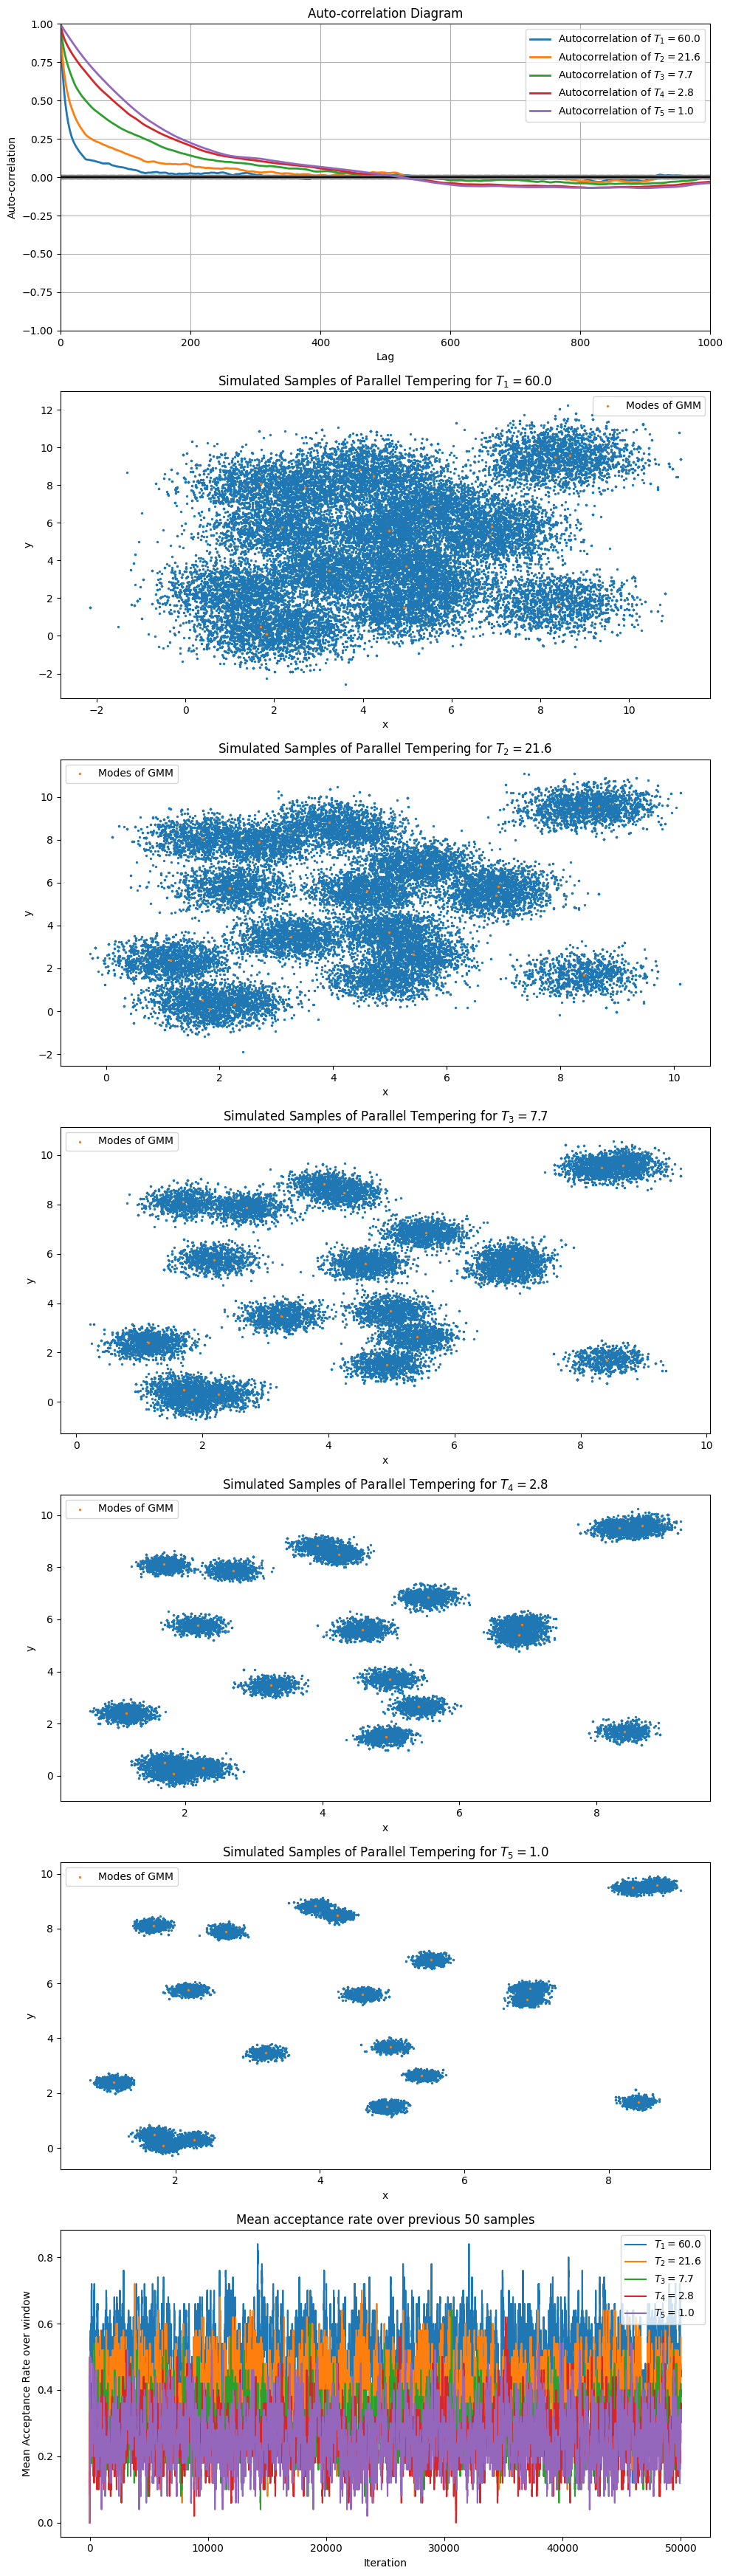

In [99]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(10, 35))

# Plot auto-correlation diagram
plt.subplot(K+2, 1, 1)
for k in range(K):
    pd.plotting.autocorrelation_plot(samples[:,k], label=fr'Autocorrelation of $T_{k+1}={temperatures[k]}$',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,1000))

#Plot samples
n_burnin = num_samples // 10
for k in range(K):
    plt.subplot(K+2, 1, k+2)
    plt.scatter(samples[n_burnin:,k, 0], samples[n_burnin:,k, 1], s=2)
    plt.scatter(mus[:, 0], mus[:, 1], s=2, label='Modes of GMM')
    plt.title(fr'Simulated Samples of Parallel Tempering for $T_{k+1}={temperatures[k]}$')
    plt.xlabel(f'x')
    plt.ylabel(f'y')
    plt.legend()

# Plot acceptance rate evolution
plt.subplot(K+2, 1, K+2)
iterations = np.arange(1, num_samples + 1)
for k in range(K):
    plt.plot(iterations, acceptance_ma[:,k], label=fr'$T_{k+1}={temperatures[k]}$')
plt.title(f'Mean acceptance rate over previous {window_size} samples')
plt.xlabel('Iteration')
plt.ylabel('Mean Acceptance Rate over window')
plt.legend()

plt.tight_layout()
plt.show()


This is indeed much more efficient. The target distribution corresponds to the last plot, with $T_5=1$. One can observe that we sample all modes and do not miss any of them. The sampling is much more accurate.

## Exercise 3

### Generate dataset

In [95]:
N=100
k_i=10
K=N*k_i

alpha = 4
beta = 3
gamma = 2
true_mu=1

def generate_dataset_random_effects(alpha, beta, gamma, mu):
    sigma_squared=invgamma.rvs(alpha,scale=beta)
    tau_squared = invgamma.rvs(gamma, scale = beta)
    X = np.random.normal(mu, np.sqrt(sigma_squared), size = (N,1))
    epsilons = np.random.normal(0, np.sqrt(tau_squared), size = (N,k_i))
    Y = X + epsilons
    return X, Y, sigma_squared, tau_squared

true_X, Y, true_sigma_squared, true_tau_squared=generate_dataset_random_effects(alpha,beta,gamma,true_mu)

In [96]:
print('sigma_squared=',true_sigma_squared)
print('tau_squared=',true_tau_squared)
print('np.mean(X)=', np.mean(true_X))
print('np.mean(Y)=', np.mean(Y))

sigma_squared= 0.4771704675531271
tau_squared= 0.9775270214790825
np.mean(X)= 0.9219072828368993
np.mean(Y)= 0.9277335282988193


### Question 2&5: Simple Gibbs sampler

In [97]:
def mcmc_Gibbs_random_effects(initial_X, initial_mu,  \
        initial_sigma_squared, initial_tau_squared, num_samples,N=N,k_i=k_i,Y=Y):
    samples_X = [initial_X]
    samples_mu= [initial_mu]
    samples_sigma_squared= [initial_sigma_squared]
    samples_tau_squared=[initial_tau_squared]

    for i in tqdm(range(1, num_samples)):
        current_X=samples_X[-1]
        current_mu=samples_mu[-1]
        current_sigma_squared=samples_sigma_squared[-1]
        current_tau_squared=samples_tau_squared[-1]
        # Updating with explicit posterior marginal conditional densities
        # Sampling from posterior of X
        for i in range(N):
            mean = (current_sigma_squared * np.sum(Y[i,:]) + current_tau_squared*current_mu) / (k_i * current_sigma_squared + current_tau_squared)
            variance = (current_sigma_squared * current_tau_squared) / (k_i * current_sigma_squared + current_tau_squared)
            current_X[i] = np.random.normal(mean, np.sqrt(variance))

        # Sampling from posterior of mu
        mean = np.sum(current_X)/N
        variance = current_sigma_squared / N
        current_mu = np.random.normal(mean, np.sqrt(variance))

        # Sampling from posterior of sigma_squared 
        loc = N/2 + alpha
        scale = beta + np.sum(np.square((current_X - current_mu)))/2
        current_sigma_squared = invgamma.rvs(loc, scale = scale)

        # Sampling from posterior of tau_squared
        loc = K/2 + gamma
        scale = beta + np.sum(np.square((Y - current_X)))/2
        current_tau_squared = invgamma.rvs(loc, scale = scale)

        samples_X.append(copy.deepcopy(current_X))
        samples_mu.append(copy.deepcopy(current_mu))
        samples_sigma_squared.append(copy.deepcopy(current_sigma_squared))
        samples_tau_squared.append(copy.deepcopy(current_tau_squared))
            
    return np.array(samples_X),np.array(samples_mu),np.array(samples_sigma_squared),np.array(samples_tau_squared)
    

In [98]:
# Initialisation of Markov Chain
initial_mu = 1
initial_sigma_squared = 2
initial_tau_squared = 3
initial_X = np.random.normal(initial_mu, np.sqrt(initial_sigma_squared), size = (N,1))

num_samples = 10000
n_burnin=num_samples//10

samples_X,samples_mu,samples_sigma_squared,samples_tau_squared=mcmc_Gibbs_random_effects(initial_X, initial_mu,  \
        initial_sigma_squared, initial_tau_squared, num_samples)

print('samples_X.shape=',samples_X.shape)
print('samples_mu.shape',samples_mu.shape)

100%|██████████| 9999/9999 [00:06<00:00, 1450.54it/s]

samples_X.shape= (10000, 100, 1)
samples_mu.shape (10000,)


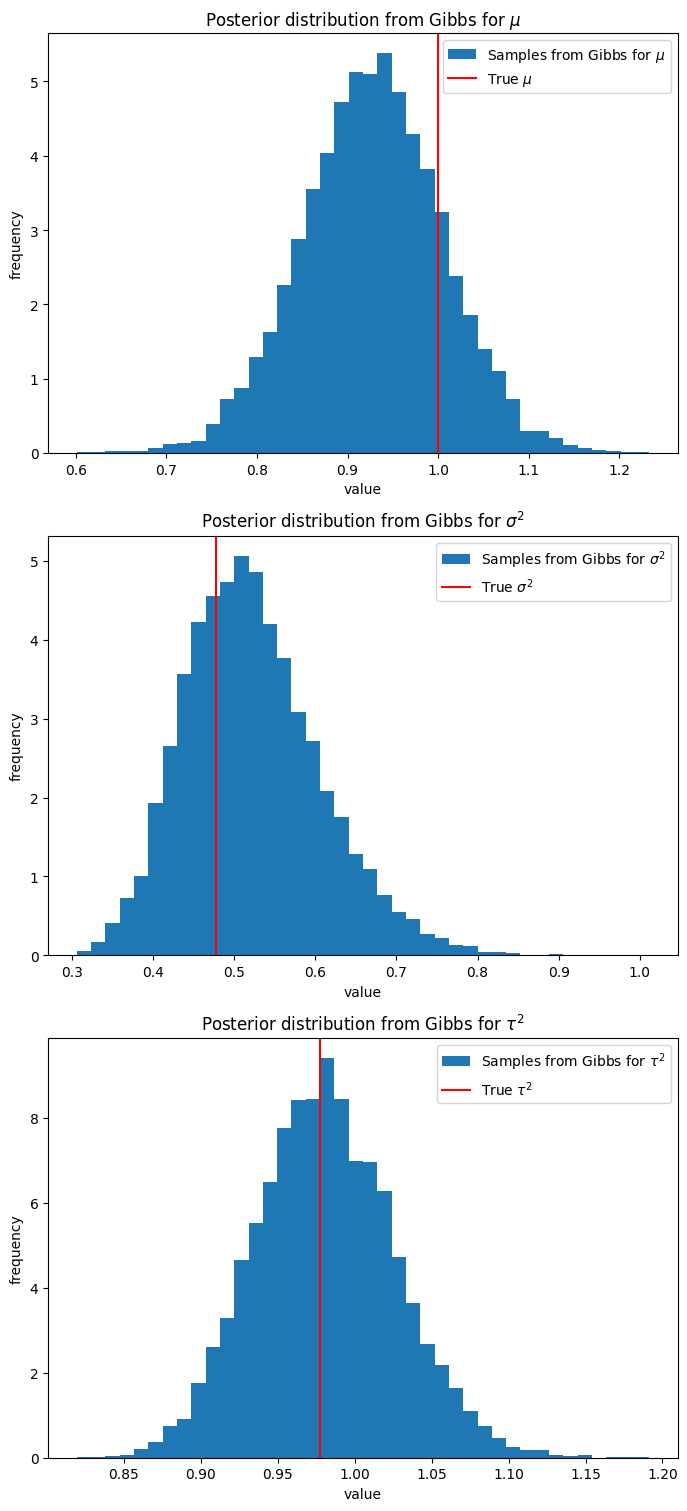

In [99]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(7, 20))

""" 
# Plot auto-correlation diagram
plt.subplot(4, 1, 1)
pd.plotting.autocorrelation_plot(samples_mu, label=fr'Autocorrelation of $\mu$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_sigma_squared, label=fr'Autocorrelation of $\sigma^2$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_tau_squared, label=fr'Autocorrelation of $\tau^2$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_X[:,:,0], label=fr'Autocorrelation of $X$',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,1000))
"""

#Plot mu samples
plt.subplot(4, 1, 2)
plt.hist(samples_mu[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\mu$')
plt.axvline(true_mu,color='red' , label = r'True $\mu$')
plt.title(fr'Posterior distribution from Gibbs for $\mu$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

#Plot sigma samples
plt.subplot(4, 1, 3)
plt.hist(samples_sigma_squared[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\sigma^2$')
plt.axvline(true_sigma_squared,color='red' , label = r'True $\sigma^2$')
plt.title(fr'Posterior distribution from Gibbs for $\sigma^2$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

#Plot tau samples
plt.subplot(4, 1, 4)
plt.hist(samples_tau_squared[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\tau^2$')
plt.axvline(true_tau_squared,color='red' , label = r'True $\tau^2$')
plt.title(fr'Posterior distribution from Gibbs for $\tau^2$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

plt.tight_layout()
plt.show()


### Question 3&5: Block-Gibbs sampler

In [100]:
@jit(nopython=True)
def inverse_covariance_matrix_Z(sigma_squared, tau_squared):
    inverse_Sigma = np.zeros((N+1,N+1))
    
    for i in range(N):
        inverse_Sigma[i,i] = (sigma_squared * k_i + tau_squared) / (sigma_squared * tau_squared)
        inverse_Sigma[i,N] = -1/sigma_squared
        inverse_Sigma[N,i] = -1/sigma_squared
    
    inverse_Sigma[N,N] = N / sigma_squared

    return Sigma

In [101]:
def mcmc_Block_Gibbs_random_effects(initial_X, initial_mu,  \
        initial_sigma_squared, initial_tau_squared, num_samples,N=N,k_i=k_i,Y=Y):
    samples_X = [initial_X]
    samples_mu= [initial_mu]
    samples_sigma_squared= [initial_sigma_squared]
    samples_tau_squared=[initial_tau_squared]

    for i in tqdm(range(1, num_samples)):
        current_X=samples_X[-1]
        current_mu=samples_mu[-1]
        current_sigma_squared=samples_sigma_squared[-1]
        current_tau_squared=samples_tau_squared[-1]
        # Updating with explicit posterior marginal conditional densities
        # Sampling from posterior of (X,mu)
        inverse_covariance = inverse_covariance_matrix_Z(current_sigma_squared, current_tau_squared)
        covariance = np.linalg.inv(inverse_covariance)
        vector = np.concatenate((np.sum(Y, axis = 1)/current_tau_squared, np.array([0]))).reshape((N+1,1))
        mean = np.matmul(covariance,vector)
        #print('mean.shape=',mean.shape)

        current_X_mu = np.random.multivariate_normal(mean = mean.reshape((N+1,)), cov = covariance, size=1)
        #print('current_X_mu.shape=',current_X_mu.shape)
        current_X_mu.reshape((N+1, 1))
        current_X = current_X_mu[:N]
        #print('current_X.shape',current_X.shape)
        current_X.reshape((N,1))
        current_mu = current_X_mu[N]

        # Sampling from posterior of sigma_squared 
        loc = N/2 + alpha
        scale = beta + np.sum(np.square((current_X - current_mu)))/2
        current_sigma_squared = invgamma.rvs(loc, scale = scale)

        # Sampling from posterior of tau_squared
        loc = K/2 + gamma
        scale = beta + np.sum(np.square((Y - current_X)))/2
        current_tau_squared = invgamma.rvs(loc, scale = scale)

        samples_X.append(copy.deepcopy(current_X))
        samples_mu.append(copy.deepcopy(current_mu))
        samples_sigma_squared.append(copy.deepcopy(current_sigma_squared))
        samples_tau_squared.append(copy.deepcopy(current_tau_squared))
            
    return np.array(samples_X),np.array(samples_mu),np.array(samples_sigma_squared),np.array(samples_tau_squared)
    

In [102]:
# Initialisation of Markov Chain
initial_mu = 0
initial_sigma_squared = 1
initial_tau_squared = 1
initial_X = np.random.normal(initial_mu, np.sqrt(initial_sigma_squared), size = (N,1))

num_samples = 50000
n_burnin=num_samples//10

samples_X,samples_mu,samples_sigma_squared,samples_tau_squared=mcmc_Gibbs_random_effects(initial_X, initial_mu,  \
        initial_sigma_squared, initial_tau_squared, num_samples)

print('samples_X.shape=',samples_X.shape)
print('samples_mu.shape',samples_mu.shape)

  0%|          | 0/49999 [00:00<?, ?it/s]

100%|██████████| 49999/49999 [00:51<00:00, 977.42it/s] 


samples_X.shape= (50000, 100, 1)
samples_mu.shape (50000,)


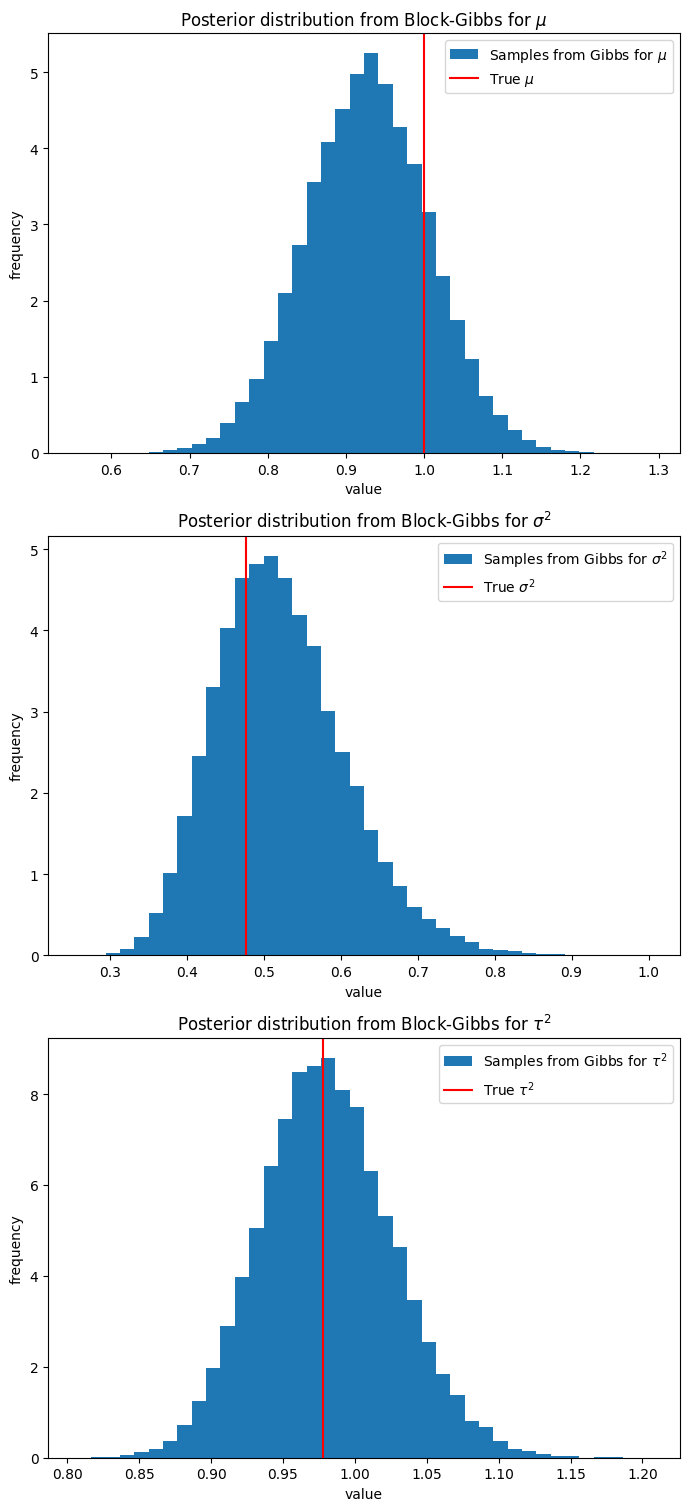

In [103]:
# Plot the trajectory of the Markov chain, auto-correlation diagram, target density, and acceptance rate evolution
plt.figure(figsize=(7, 20))

""" 
# Plot auto-correlation diagram
plt.subplot(4, 1, 1)
pd.plotting.autocorrelation_plot(samples_mu, label=fr'Autocorrelation of $\mu$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_sigma_squared, label=fr'Autocorrelation of $\sigma^2$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_tau_squared, label=fr'Autocorrelation of $\tau^2$',linewidth=2)
pd.plotting.autocorrelation_plot(samples_X[:,:,0], label=fr'Autocorrelation of $X$',linewidth=2)
plt.title('Auto-correlation Diagram')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.legend()
plt.xlim((0,1000))
"""

#Plot mu samples
plt.subplot(4, 1, 2)
plt.hist(samples_mu[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\mu$')
plt.axvline(true_mu,color='red' , label = r'True $\mu$')
plt.title(fr'Posterior distribution from Block-Gibbs for $\mu$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

#Plot sigma samples
plt.subplot(4, 1, 3)
plt.hist(samples_sigma_squared[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\sigma^2$')
plt.axvline(true_sigma_squared,color='red' , label = r'True $\sigma^2$')
plt.title(fr'Posterior distribution from Block-Gibbs for $\sigma^2$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

#Plot tau samples
plt.subplot(4, 1, 4)
plt.hist(samples_tau_squared[n_burnin:], bins = 40, density = True, label =r'Samples from Gibbs for $\tau^2$')
plt.axvline(true_tau_squared,color='red' , label = r'True $\tau^2$')
plt.title(fr'Posterior distribution from Block-Gibbs for $\tau^2$')
plt.xlabel(f'value')
plt.ylabel(f'frequency')
plt.legend()

plt.tight_layout()
plt.show()


### Question 4: Discussion of theoretical performance

Block-Gibbs can offer faster convergence by updating multiple variables at once, especially in high-dimensional settings. Here, since the $(X,\mu)$ block can easily be sampled (because it follows a normal distribution), it has to be, theoretically, a gain of time. Yet, here, we just gain one update out of N+3, where $N$ is typically about 100, per iteration of the Gibbs algorithm, which is not substantial. 
This can be observed in the figures, which seem to be the same for the simple and Block-Gibbs sampling.